In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import TensorBoard
from keras.layers import *
import numpy

from sklearn.model_selection import train_test_split

#ignoring the first row (header) 
# and the first column (unique experiment id, which I'm not using here)
dataset = numpy.loadtxt("/results/shadow_robot_dataset.csv", skiprows=1, usecols=range(1,30), delimiter=",")

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


# Loading the data

Each row of my dataset contains the following:

|0 | 1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
| experiment_number | robustness| H1_F1J2_pos | H1_F1J2_vel | H1_F1J2_effort | H1_F1J3_pos | H1_F1J3_vel | H1_F1J3_effort | H1_F1J1_pos | H1_F1J1_vel | H1_F1J1_effort | H1_F3J1_pos | H1_F3J1_vel | H1_F3J1_effort | H1_F3J2_pos | H1_F3J2_vel | H1_F3J2_effort | H1_F3J3_pos | H1_F3J3_vel | H1_F3J3_effort |  H1_F2J1_pos | H1_F2J1_vel | H1_F2J1_effort | H1_F2J3_pos | H1_F2J3_vel | H1_F2J3_effort | H1_F2J2_pos | H1_F2J2_vel | H1_F2J2_effort | measurement_number|

My input vector contains the velocity and effort for each joint. I'm creating the vector `X` containing those below:

In [3]:
# Getting the header
header = ""

with open('/results/shadow_robot_dataset.csv', 'r') as f:
    header = f.readline()
    
header = header.strip("\n").split(',')
header = [i.strip(" ") for i in header]

# only use velocity and effort, not position
saved_cols = []
for index,col in enumerate(header[1:]):
    if ("vel" in col) or ("eff" in col):
        saved_cols.append(index)
        
new_X = []
for x in dataset:
    new_X.append([x[i] for i in saved_cols])
   
X = numpy.array(new_X)


My output vector is the predicted grasp robustness. 

In [5]:
Y = dataset[:,0]

We are also splitting the dataset into a training set and a test set. 

This gives us 4 sets: 
* `X_train` associated to its `Y_train`
* `X_test` associated to its `Y_test`

We also discretize the output: 1 is a stable grasp and 0 is unstable. A grasp is considered stable if the robustness value is more than 100.

In [7]:
# fix random seed for reproducibility
# and splitting the dataset
seed = 7
numpy.random.seed(seed)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=seed)

# this is a sensible grasp threshold for stability
GOOD_GRASP_THRESHOLD = 50

# we're also storing the best and worst grasps of the test set to do some sanity checks on them
itemindex = numpy.where(Y_test>1.05*GOOD_GRASP_THRESHOLD)
best_grasps = X_test[itemindex[0]]
itemindex = numpy.where(Y_test<=0.95*GOOD_GRASP_THRESHOLD)
bad_grasps = X_test[itemindex[0]]

# discretizing the grasp quality for stable or unstable grasps
Y_train = numpy.array([int(i>GOOD_GRASP_THRESHOLD) for i in Y_train])
Y_train = numpy.reshape(Y_train, (Y_train.shape[0],))

Y_test = numpy.array([int(i>GOOD_GRASP_THRESHOLD) for i in Y_test])
Y_test = numpy.reshape(Y_test, (Y_test.shape[0],))

# Creating the model

I'm now creating a model to train. It's a very simple topology. Feel free to play with it and experiment with different model shapes.

In [8]:
# create model
model = Sequential()

model.add(Dense(20*len(X[0]), use_bias=True, input_dim=len(X[0]), activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model

The model training should be relatively quick. To speed it up you can use a GPU :)

I'm using 80% of the data for training and 20% for validation.

In [9]:
model.fit(X_train, Y_train, validation_split=0.20, epochs=50,
          batch_size=500000)

Train on 635289 samples, validate on 158823 samples
Epoch 1/50
635289/635289 [==============================] - 21s - loss: 1.0522 - acc: 0.4108 - val_loss: 0.4919 - val_acc: 0.6370
Epoch 2/50
635289/635289 [==============================] - 6s - loss: 0.6931 - acc: 0.4742 - val_loss: 0.3576 - val_acc: 0.6560
Epoch 3/50
635289/635289 [==============================] - 6s - loss: 0.4839 - acc: 0.5830 - val_loss: 0.3343 - val_acc: 0.6545
Epoch 4/50
635289/635289 [==============================] - 6s - loss: 0.4019 - acc: 0.6293 - val_loss: 0.3379 - val_acc: 0.6544
Epoch 5/50
635289/635289 [==============================] - 6s - loss: 0.3755 - acc: 0.6446 - val_loss: 0.3456 - val_acc: 0.6544
Epoch 6/50
635289/635289 [==============================] - 6s - loss: 0.3702 - acc: 0.6497 - val_loss: 0.3523 - val_acc: 0.6544
Epoch 7/50
635289/635289 [==============================] - 6s - loss: 0.3698 - acc: 0.6528 - val_loss: 0.3572 - val_acc: 0.7986
Epoch 8/50
635289/635289 [==================

Now that the model is trained I'm saving it to be able to load it easily later on.

In [10]:
import h5py
model.save("./model.h5")

# Evaluating the model

First let's see how this model performs on the test set - which hasn't been used during the training phase.

In [12]:
scores = model.evaluate(X_test, Y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

197632/198529 [============================>.] - ETA: 0s
acc: 97.33%


Now let's take a quick look at the good grasps we stored earlier. Are they correctly predicted as stable?

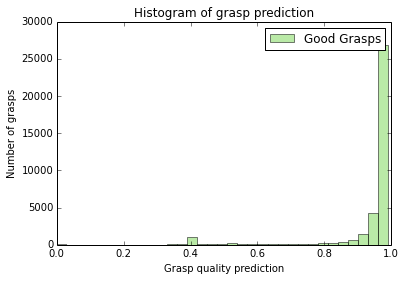

In [20]:
predictions = model.predict(best_grasps)

%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(predictions,
         color='#77D651',
         alpha=0.5,
         label='Good Grasps',
         bins=np.arange(0.0, 1.0, 0.03))

plt.title('Histogram of grasp prediction')
plt.ylabel('Number of grasps')
plt.xlabel('Grasp quality prediction')
plt.legend(loc='upper right')

plt.show()

Most of the grasps are correctly predicted as stable (the grasp quality prediction is more than 0.5)! Looking good.

What about the unstable grasps?

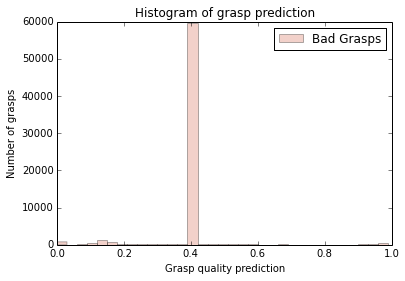

In [19]:
predictions_bad_grasp = model.predict(bad_grasps)


# Plot a histogram of defender size
plt.hist(predictions_bad_grasp,
         color='#D66751',
         alpha=0.3,
         label='Bad Grasps',
         bins=np.arange(0.0, 1.0, 0.03))

plt.title('Histogram of grasp prediction')
plt.ylabel('Number of grasps')
plt.xlabel('Grasp quality prediction')
plt.legend(loc='upper right')

plt.show()

Most of the grasps are considered unstable - below 0.5 - with a few bad classification.